Here we test if we can interate $r_{d}$ for the GILA model.

In [1]:
#Import libraries related to BAO data.
import numpy as np
from numba import jit
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz as cumtrapz
from scipy.integrate import simps as simps
from scipy.integrate import quad as quad
from change_of_parameters import F_H#, omega_luisa_to_CDM

from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000

import time
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_datos_global = os.path.dirname(path_git)
os.chdir(path_git)
os.sys.path.append('./fr_mcmc/utils/')
from change_of_parameters import omega_CDM_to_luisa, omega_luisa_to_CDM
from LambdaCDM import H_LCDM_rad
from solve_sys import F_H_prime


Lets define some functions for the calculations of the rd for LCDM

In [2]:
#Parameters order: omega_m,b,H_0,n

def zdrag(omega_m,H_0,wb=0.0225):
    '''
    wb = 0.0222383 #Planck
    wb = 0.0225 #BBN
    '''
    h = H_0/100
    b1 = 0.313*(omega_m*h**2)**(-0.419)*(1+0.607*(omega_m*h**2)**(0.6748))
    b2 = 0.238*(omega_m*h**2)**0.223
    zd = (1291*(omega_m*h**2)**0.251) * (1+b1*wb**b2) /(1+0.659*(omega_m*h**2)**0.828)
    #zd =1060.31
    return zd

@jit
def integrand(z, Om_m_0, H_0, wb):
    R_bar = wb * 10**5 / 2.473

    Om_r = 4.18343*10**(-5) / (H_0/100)**2
    Om_Lambda = 1 - Om_m_0 - Om_r
    H = H_0 * ((Om_r * (1 + z)**4 + Om_m_0 * (1 + z)**3 + Om_Lambda) ** (1/2))
    return c_light_km/(H * (3*(1 + R_bar*(1+z)**(-1)))**(1/2))


def r_drag_lcdm(omega_m,H_0,wb = 0.0225, int_z=True): #wb of BBN as default.
    #rd calculation:
    h = H_0/100
    zd = zdrag(omega_m,H_0)
    #R_bar = 31500 * wb * (2.726/2.7)**(-4)
    R_bar = wb * 10**5 / 2.473

    #zd calculation:
    zd = zdrag(omega_m, H_0)
    # zd = 1000
    R_bar = wb * 10**5 / 2.473

    rd_log, _ = quad(lambda z: integrand(z, omega_m, H_0, wb), zd, np.inf)

    return rd_log


Now we check that this work:

In [3]:
H_0 = 70
omega_m = 0.3

rd_lcdm = r_drag_lcdm(omega_m,H_0,wb = 0.0225)
print(rd_lcdm)

144.6910269819528


Now we define extra functions in order to calculate rd from GILA model. First, let's define the ODE for the integration of $\frac{1}{H} (z)$

In [27]:

def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'HS'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    #kappa = 8 * np.pi * G_newton / 3
    kappa = 1

    [lamb, L, b, L_bar, H_0, omega_m_0] = params_ode


    #omega_m_0 = 0.999916 #omega_m_0 es el de Luisa
    omega_r_0 = 1 - omega_m_0

    F_H0 = F_H(H_0, [lamb, L, b, L_bar])

    if lcdm == True:
        rho_crit_0 = H_0**2 / kappa        
    else:
        rho_crit_0 = F_H0 / kappa
    #print(omega_m_0,F_H0,rho_crit_0)
    a = 1/(1+z)

    rho_r = rho_crit_0 * omega_r_0 * a**(-4)
    rho_m = rho_crit_0 * omega_m_0 * a**(-3)
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * kappa * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [lamb, L, b, L_bar]))     
    #print(s)
    return s


def integrator_GILA(physical_params, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    
    L_bar, b, H0, omega_m_luisa = physical_params
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    ode_params = [0, 1e-27/H0, b, L_bar/H0, H0, omega_m_luisa]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    #assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    #assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

def get_odes_inv(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'HS'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    #kappa = 8 * np.pi * G_newton / 3
    kappa = 1

    [lamb, L, b, L_bar, H_0, omega_m_0] = params_ode


    #omega_m_0 = 0.999916 #omega_m_0 es el de Luisa
    omega_r_0 = 1 - omega_m_0

    F_H0 = F_H(H_0, [lamb, L, b, L_bar])

    if lcdm == True:
        rho_crit_0 = H_0**2 / kappa        
    else:
        rho_crit_0 = F_H0 / kappa
    #print(omega_m_0,F_H0,rho_crit_0)
    a = 1/(1+z)

    rho_r = rho_crit_0 * omega_r_0 * a**(-4)
    rho_m = rho_crit_0 * omega_m_0 * a**(-3)
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =   - 3 * kappa * (rho_tot + p_tot/c_light_km**2) / ((1+z)*(Hubble**2)*F_H_prime(Hubble, [lamb, L, b, L_bar]))     
    #print(s)
    return s


def integrator_GILA_inv(physical_params, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes_inv, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    
    L_bar, b, H0, omega_m_luisa = physical_params
    
    zs_int = np.linspace(initial_z, final_z, num_z_points)

    ode_params = [0, 1e-27/H0, b, L_bar/H0, H0, omega_m_luisa]

    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [1/H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        
    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final_inv = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final_inv



In [24]:
L_bar = 0.75
b = 2
omega_m_luisa = omega_CDM_to_luisa(b, L_bar, H_0, omega_m)
 

physical_params = [L_bar,b,H_0,omega_m_luisa]


zs_model, Hs_model = integrator_GILA(physical_params, num_z_points=int(10e5), initial_z = 0, final_z=int(4))
print(zs_model, Hs_model)

zs_model_inv, Hs_inv_model = integrator_GILA_inv(physical_params, num_z_points=int(10e5), initial_z = 0, final_z=int(4))
print(zs_model_inv, Hs_inv_model)



'''
@jit
def integrand_GILA(z, wb):
    R_bar = wb * 10**5 / 2.473
    aux = interp1d(zs_model, Hs_inv_model)
    H_inv = aux(z)
    return H_inv * c_light_km/((3*(1 + R_bar*(1+z)**(-1)))**(1/2))


def r_drag_GILA(omega_m,H_0,wb = 0.0225, int_z=True): #wb of BBN as default.
    zd = zdrag(omega_m, H_0)
    rd, _ = quad(lambda z: integrand_GILA(z, wb), zd, int(10e4))
    return rd

#print(r_drag_GILA(omega_m, H_0, wb = 0.0225, int_z=True))
'''

[0.00000000e+00 4.00000400e-06 8.00000800e-06 ... 2.23800224e-02
 2.23840224e-02 2.23880224e-02] [70.         69.99960301 69.99920598 ... 65.08771303 65.05739785
 64.99833047]
[0.000000e+00 4.000004e-06 8.000008e-06 ... 3.999992e+00 3.999996e+00
 4.000000e+00] [1.42857143e-02 5.23182550e-01 6.22173447e-01 ... 4.47425484e+01
 4.47425865e+01 4.47426246e+01]


'\n@jit\ndef integrand_GILA(z, wb):\n    R_bar = wb * 10**5 / 2.473\n    aux = interp1d(zs_model, Hs_inv_model)\n    H_inv = aux(z)\n    return H_inv * c_light_km/((3*(1 + R_bar*(1+z)**(-1)))**(1/2))\n\n\ndef r_drag_GILA(omega_m,H_0,wb = 0.0225, int_z=True): #wb of BBN as default.\n    zd = zdrag(omega_m, H_0)\n    rd, _ = quad(lambda z: integrand_GILA(z, wb), zd, int(10e4))\n    return rd\n\n#print(r_drag_GILA(omega_m, H_0, wb = 0.0225, int_z=True))\n'

Finally, lets compare results

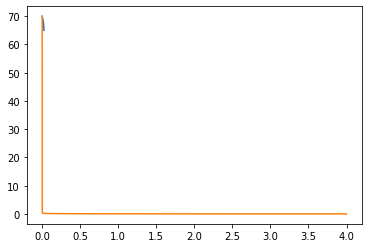

In [26]:
from matplotlib import pyplot as plt
plt.plot(zs_model, Hs_model)
plt.plot(zs_model_inv, (Hs_inv_model)**(-1))

In [7]:
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir

os.chdir(path_git); os.sys.path.append('./fr_mcmc/utils/')
from change_of_parameters import omega_CDM_to_luisa, omega_luisa_to_CDM
from solve_sys import Hubble_th

L_bar = 0.75
b = 2
H_0 = 70

#omega_m_luisa = 0.9999 + 10**(-5) * omega_m_luisa
#omega_m = omega_luisa_to_CDM(b,L_bar,H_0,omega_m_luisa)
omega_m = 0.3
omega_m_luisa = omega_CDM_to_luisa(b, L_bar, H_0, omega_m)

rd = r_drag_lcdm(omega_m,H_0,wb = 0.0225)

physical_params = [L_bar,b,H_0,omega_m_luisa]
zs_model, Hs_model = Hubble_th(physical_params, model='GILA',
                            z_min= zdrag(omega_m,H_0), z_max=np.inf)
print(rd)

@jit
def integrand_GILA(z, Om_m_0, H_0, wb):
    R_bar = wb * 10**5 / 2.473

    Om_r = 4.18343*10**(-5) / (H_0/100)**2
    Om_Lambda = 1 - Om_m_0 - Om_r
    aux = interp1d(zs_model, Hs_model)
    H = aux(z)
    #H = H_0 * ((Om_r * (1 + z)**4 + Om_m_0 * (1 + z)**3 + Om_Lambda) ** (1/2))
    return c_light_km/(H * (3*(1 + R_bar*(1+z)**(-1)))**(1/2))


def r_drag_GILA(omega_m,H_0,wb = 0.0225, int_z=True): #wb of BBN as default.
    #rd calculation:
    h = H_0/100
    zd = zdrag(omega_m,H_0)
    #R_bar = 31500 * wb * (2.726/2.7)**(-4)
    R_bar = wb * 10**5 / 2.473

    #zd calculation:
    zd = zdrag(omega_m, H_0)
    # zd = 1000
    R_bar = wb * 10**5 / 2.473

    rd_log, _ = quad(lambda z: integrand_GILA(z, omega_m, H_0, wb), zd, np.inf)

    return rd_log


print(r_drag_GILA(omega_m,H_0,wb = 0.0225, int_z=True))



144.6910269819528


/tmp/ipykernel_23986/2290218277.py:25: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "integrand_GILA" failed type inference due to: Untyped global name 'interp1d': Cannot determine Numba type of <class 'type'>

File "../../../../../tmp/ipykernel_23986/2290218277.py", line 31:
<source missing, REPL/exec in use?>

  @jit
/home/matias/.local/lib/python3.7/site-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "integrand_GILA" was compiled in object mode without forceobj=True.

File "../../../../../tmp/ipykernel_23986/2290218277.py", line 25:
<source missing, REPL/exec in use?>

  state.func_ir.loc))
/home/matias/.local/lib/python3.7/site-packages/numba/core/object_mode_passes.py:162: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/

ValueError: A value in x_new is above the interpolation range.